In [52]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import geojson
from tqdm.notebook import tqdm

from shapely.geometry import shape, MultiPolygon, Point, Polygon
import os
import sys
sys.path.append('../src/')
from utils import save_pickle, load_pickle

#mapbox key for isochrones
token = 'pk.eyJ1IjoiZXZnZW5paWdhdnJpbGluIiwiYSI6ImNrMG50N3ptdjAzNW8zbm8wZzVmaXpzcWoifQ.LMSJohnSoBN-6YlAgKPO0w'


In [103]:
def get_isochrone(coord, kind = 'driving', minutes = '5,10,15,20'):
    """
    
    """
    request = f'https://api.mapbox.com/isochrone/v1/mapbox/{kind}/{coord.x},{coord.y}?contours_minutes={minutes}&polygons=true&access_token={token}'
    r = requests.get(request)  
    return geojson.loads(r.content)


In [184]:
df_home_job = pd.read_csv("../data/raw/01_CLocation_July.csv")
df_shape = gpd.read_file("../data/raw/fishnet2021/fishnet2021.shp")
df_home_job.rename(columns={'zid': 'cell_zid'}, inplace=True)

df_home_job = pd.merge(df_home_job, shape, on = ['cell_zid'])
df_home_job['center'] = df_home_job['geometry'].map(lambda poly: poly.centroid)

In [104]:
isochrone_file_path = "../data/precessed/isochrones_walk.pkl"
if os.path.exists(isochrone_file_path):
    isochrones_walk = load_pickle(isochrone_file_path)
else:
    print("empty")
    isochrones_walk = {}

In [118]:
for idx, row in tqdm(df_home_job.iterrows(), total=len(df_home_job)):
    if row['cell_zid'] in isochrones_walk.keys():
        if 'features' in isochrones_walk[row['cell_zid']].keys():
            continue
    isochrones_walk[row['cell_zid']] = get_isochrone(row['center'], kind = 'walking')
    if idx %100 == 0:
        save_pickle(isochrones_walk, "../data/precessed/isochrones_walk.pkl")
save_pickle(isochrones_walk, "../data/precessed/isochrones_walk.pkl")        

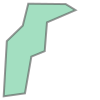

In [106]:
Polygon(isochrones_walk[32909]['features'][3]['geometry']['coordinates'][0])

In [123]:
l_5 = []
l_10 = []
l_15 = []
l_20 = []
for zid in isochrones_walk.keys():
    l_5.append((zid,Polygon(isochrones_walk[zid]['features'][3]['geometry']['coordinates'][0])))
    l_10.append((zid,Polygon(isochrones_walk[zid]['features'][2]['geometry']['coordinates'][0])))
    l_15.append((zid,Polygon(isochrones_walk[zid]['features'][1]['geometry']['coordinates'][0])))
    l_20.append((zid,Polygon(isochrones_walk[zid]['features'][0]['geometry']['coordinates'][0])))

In [124]:
df_5 = pd.DataFrame(l_5, columns = ['zid', 'geometry'])
df_5['geometry'] = df_5['geometry'].astype(str)
df_10 = pd.DataFrame(l_10, columns = ['zid', 'geometry'])
df_10['geometry'] = df_10['geometry'].astype(str)
df_15 = pd.DataFrame(l_15, columns = ['zid', 'geometry'])
df_15['geometry'] = df_15['geometry'].astype(str)
df_20 = pd.DataFrame(l_20, columns = ['zid', 'geometry'])
df_20['geometry'] = df_20['geometry'].astype(str)

In [129]:
df_home_job['geometry'] = df_home_job['geometry'].astype(str)

In [133]:
df_home_job

,cell_zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move,geometry,center
0,32909,4,0,0,0,"POLYGON ((37.03351220866129 55.14028664630594,...",POINT (37.03740694989381 55.1425474465426)
1,32910,25,8,26,0,"POLYGON ((37.04135364622309 55.14031640325421,...",POINT (37.0452488350607 55.14257695359622)
2,33261,2,0,2,0,"POLYGON ((37.02561751031512 55.14474813716326,...",POINT (37.02951223685058 55.14700918795363)
3,33262,13,2,11,0,"POLYGON ((37.03345981389939 55.14477840355769,...",POINT (37.03735498836724 55.14703920431827)
4,33263,10,0,3,0,"POLYGON ((37.04130213212256 55.14480816490281,...",POINT (37.04519775415532 55.14706871627504)
...,...,...,...,...,...,...,...
10235,138913,77,455,495,1,"POLYGON ((37.17539226107255 56.0121198228514, ...",POINT (37.17938228624779 56.01437588232672)
10236,138914,165,796,884,8,"POLYGON ((37.18340951375081 56.01214066033057,...",POINT (37.187400009301 56.0143964609985)
10237,138915,587,1341,1661,19,"POLYGON ((37.1914267768936 56.01216097673462, ...",POINT (37.19541774366687 56.01441651855303)
10238,138916,1206,1669,2177,47,"POLYGON ((37.19944405219302 56.01218077206691,...",POINT (37.20343548810177 56.01443605498648)


In [135]:
from keplergl import KeplerGl
map_config = load_pickle("../configs/map_config_base.pkl")

map_1 = KeplerGl(height = 700, config = map_config)
map_1.add_data(df_15, name='shape')
map_1.add_data(df_home_job.drop(['center'], 1), name='population')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hab79n', 'type': '…

In [134]:
save_pickle(map_1.config, "../configs/map_config_base.pkl")

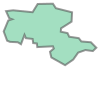

In [144]:
df_15 = pd.DataFrame(l_15, columns = ['zid', 'geometry'])
df_15[df_15['zid'] == 96243]['geometry'].iloc[0]